# Importing Libraries

In [1]:
!nvidia-smi


Thu May  4 04:24:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.1 MB/s eta 0:00:00


In [3]:
import torch
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import string
import collections
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers.tokenization_utils_base import BatchEncoding
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

pd.set_option('max_colwidth', 500)
%matplotlib inline

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
BERT_MODEL_NAME = 'bert-base-uncased'

# Data Preprocessing Squad 2.0

In [6]:
def squad_load_from_json(json_file_path: str):
  with open(json_file_path, "r") as f:
    json_data = json.load(f)['data']
    questions = []
    answers = []
    corpuses = []
    for category in json_data:
      for paragraph in category['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
          corpuses.append(context)
          question = qa['question']
          questions.append(question)
          if qa['is_impossible']:
            ans_list = qa['plausible_answers']
          else:
            ans_list = qa['answers']
          ans_set = set()
          if len(ans_list) == 0:
            print("Question ", question, " has no answers")
          for idx, ans in enumerate(ans_list):
            ans_set.add((ans['answer_start'], ans['answer_start']+len(ans['text']), ans['text']))
          answers.append(list(ans_set))
    return pd.DataFrame(data={'question':questions, 'answer':answers, 'corpus':corpuses})

In [7]:
train_dataset = squad_load_from_json("/content/drive/MyDrive/NeuralNets/Dataset/train-v2.0.json")
#train_dataset

In [8]:
validation_dataset = squad_load_from_json("/content/drive/MyDrive/NeuralNets/Dataset/dev-v2.0.json")
#validation_dataset

Question  What was proven in 2001 in regard to the solid oxygen phase?  has no answers
Question  What was discovered in 2006 in regard to O4?  has no answers
Question  What does air in equilibrium with water contain?  has no answers
Question  What is paired oxygen?  has no answers
Question  Why are O molecules paramagnetic?  has no answers
Question  What is formula for the reactive oxygen ion?  has no answers
Question  What are products of oxygen use in organisms?   has no answers
Question  What began to accumulate 5.2 billion years ago?  has no answers
Question  What is red in both the liquid and solid states?  has no answers
Question  Why do polar oceans support reduced amounts of life?  has no answers
Question  What involves delivering a gas stream that is 9% to 93% O2?  has no answers
Question  What do oxoacids evolve from?  has no answers
Question  What is the essential purpose of supplementation?   has no answers
Question  In case of cabin pressurization, what is available to pas

In [9]:
train_dataset = train_dataset.explode('answer').reset_index()
#train_dataset

In [10]:
validation_dataset = validation_dataset.explode('answer').reset_index()
#validation_dataset

In [11]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

# Tokenization

In [12]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
  ans_tok_start = []
  ans_tok_end = []
  ans_tok_text = []
  for idx, ans in enumerate(dataset['answer'].values):
    if not pd.isna(ans):
      ans_text_start = ans[0]
      ans_text_end = ans[1]
      ans_text = ans[2]
      encoding = tokenizer.encode_plus(text=dataset['corpus'].values[idx], text_pair=dataset['question'].values[idx], max_length=512, padding='max_length', truncation=True)
      ans_start = encoding.char_to_token(0, ans_text_start)
      ans_end = encoding.char_to_token(0, ans_text_end-1)
      # Handle truncated answers
      if ans_start is None:
        ans_start = ans_end = tokenizer.model_max_length
      elif ans_end is None:
        ans_end = [i for i, inp in enumerate(encoding['input_ids']) if inp == tokenizer.sep_token_id][0]
      # Wrong because it gives free score points on truncated answers. Fixed this on the cross evaluation script.
      ans_text_tok = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end+1]))
    else:
      ans_start = ans_end = tokenizer.model_max_length
      ans_text_tok = ""
    ans_tok_start.append(ans_start)
    ans_tok_end.append(ans_end)
    ans_tok_text.append(ans_text_tok)
  dataset['ans_start_tok'] = ans_tok_start
  dataset['ans_end_tok'] = ans_tok_end
  dataset['ans_tok_text'] = ans_tok_text
  return dataset

In [13]:
train_dataset = calculate_tokenized_ans_indices(train_dataset)
#train_dataset

In [14]:
validation_dataset = calculate_tokenized_ans_indices(validation_dataset)

# Metrics

In [15]:
from nltk.tokenize import word_tokenize
from nltk.translate import bleu_score

'''# define a function to tokenize and normalize text
def normalize(text):
    return " ".join(word_tokenize(text)).lower()'''

def metrics(predictions, references):
  def normalize(s):
      """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
      import string, re

      def remove_articles(text):
          regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
          return re.sub(regex, " ", text)

      def white_space_fix(text):
          return " ".join(text.split())

      def remove_punc(text):
          exclude = set(string.punctuation)
          return "".join(ch for ch in text if ch not in exclude)

      def lower(text):
          return text.lower()

      return white_space_fix(remove_articles(remove_punc(lower(s))))

  # assume that `predictions` and `references` are lists of strings representing predicted and actual answers
  total_em = 0
  total_f1 = 0
  for pred, ref in zip(predictions, list(references)):
      pred = normalize(pred)
      ref = normalize(ref)
      if pred == ref:
          total_em += 1
      total_f1 += bleu_score.sentence_bleu([ref], pred)

  exact_match = total_em / len(predictions)
  f1_score = total_f1 / len(predictions)
  
  print("F1-Score",f1_score )
  print("Exact Match score",exact_match)
  
  return f1_score, exact_match


# BERT

In [16]:
from transformers import pipeline, BertForQuestionAnswering, BertTokenizer

qa_model_bert = pipeline(
    "question-answering",
    model=BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad"),
    tokenizer=BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
)


In [17]:
references = train_dataset.iloc[:50,:]['answer']

In [18]:
predictions=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions.append(qa_model_bert(train_dataset.iloc[i,1],train_dataset.iloc[i,3])['answer'] )
  #calculate_exact_match_metric(data['answer'][i], predictions)


In [ ]:
# Initialize an empty list to store the second elements
answers = []

# Loop through each tuple in the list and append the second element to the new list
for tup in references:
    answers.append(tup[2])

In [ ]:
metrics(predictions, answers)

F1-Score 0.918018998974031
Exact Match score 0.92


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


(0.918018998974031, 0.92)

# Distil BERT

In [ ]:
from transformers import pipeline

# Download the pre-trained Distil BERT model for question answering on Squad
qa_model_distil = pipeline(
    "question-answering",
    model="distilbert-base-cased-distilled-squad",
    tokenizer="distilbert-base-cased",
)


In [ ]:
predictions_distil=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions_distil.append(qa_model_distil(train_dataset.iloc[i,1],train_dataset.iloc[i,3])['answer'] )
  #calculate_exact_match_metric(data['answer'][i], predictions)

In [ ]:
metrics(predictions_distil, answers)

F1-Score 0.9068440828188814
Exact Match score 0.92


(0.9068440828188814, 0.92)

# RoBERTa

In [ ]:
from transformers import RobertaForQuestionAnswering, RobertaTokenizer, pipeline

qa_model_roberta = pipeline(
    "question-answering",
    model=RobertaForQuestionAnswering.from_pretrained("deepset/roberta-large-squad2"),
    tokenizer=RobertaTokenizer.from_pretrained("deepset/roberta-large-squad2")
)


In [ ]:
predictions_roberta=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions_roberta.append(qa_model_roberta(train_dataset.iloc[i,1],train_dataset.iloc[i,3])['answer'] )

In [ ]:
metrics(predictions_roberta, answers)

F1-Score 0.930196322627038
Exact Match score 0.94


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


(0.930196322627038, 0.94)

# Electra

In [ ]:
from transformers import pipeline, ElectraForQuestionAnswering, ElectraTokenizer

#model = ElectraForQuestionAnswering.from_pretrained("google/electra-base-discriminator")
#tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")

qa_model_electra = pipeline(
    "question-answering",
    model=ElectraForQuestionAnswering.from_pretrained("google/electra-base-discriminator"),
    tokenizer=ElectraTokenizer.from_pretrained("google/electra-base-discriminator")
)


Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForQuestionAnswering: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.we

In [ ]:
predictions_electra=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions_electra.append(qa_model_electra(train_dataset.iloc[i,1],train_dataset.iloc[i,3])['answer'] )

In [ ]:
metrics(predictions_electra, answers)

F1-Score 0.026409073825098762
Exact Match score 0.0


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


(0.026409073825098762, 0.0)

# Ensemble - BERT + DistilBERT

In [ ]:
# Define a function that takes a question and returns the answer from both models
def ensemble_predict(question, context):
    # Use the first model to predict the answer
    answer_1 = qa_model_bert(question=question, context=context)["answer"]

    # Use the second model to predict the answer
    answer_2 = qa_model_distil(question=question, context=context)["answer"]

    # Combine the answers from both models using majority voting
    answer_list = [answer_1, answer_2]
    majority_vote = max(set(answer_list), key=answer_list.count)
    return majority_vote

In [ ]:
predictions_en1=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions_en1.append(ensemble_predict(train_dataset.iloc[i,1],train_dataset.iloc[i,3]) ) #['answer']

In [ ]:
metrics(predictions_en1, answers)

F1-Score 0.9142016716423104
Exact Match score 0.92


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


(0.9142016716423104, 0.92)

# Ensemble - Weighted 

In [ ]:
from collections import Counter

def ensemble_wt(question, context):
    # Use the first model to predict the answer
    answer_1 = qa_model_bert(question=question, context=context)["answer"]

    # Use the second model to predict the answer
    answer_2 = qa_model_distil(question=question, context=context)["answer"]

    # Use the third model to predict the answer
    #answer_ = ensemble_predict(question=question, context=context)#["answer"]

    # Use the fourth model to predict the answer
    answer_3 = qa_model_roberta(question=question, context=context)["answer"]

    # Use the fifth model to predict the answer
    #answer_5 = qa_model_electra(question=question, context=context)["answer"]

    # Compute the mode of the predicted answers weighted by their respective weights
    weighted_answers = [answer_1] * 3 + [answer_2] * 2 + 5* [answer_3] #+ [answer_4] + [answer_5]
    weighted_scores = [0.3] *3  + [0.3] * 2 + [0.4]*5 #+ [0.05] + [0.05]
    answer_counter = Counter(weighted_answers)
    mode_answer = max(answer_counter, key=lambda answer: answer_counter[answer] * weighted_scores[weighted_answers.index(answer)])
    
    return mode_answer

In [ ]:
predictions_en2=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions_en2.append(ensemble_wt(train_dataset.iloc[i,1],train_dataset.iloc[i,3]) ) #['answer'] ,train_dataset.iloc[i,3],answers[i]

In [ ]:
metrics(predictions_en2, answers)

F1-Score 0.930196322627038
Exact Match score 0.94


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


(0.930196322627038, 0.94)

# Ensemble - Majority

In [ ]:
def ensemble_majority(question, context):
    # Use the first model to predict the answer
    answer_1 = qa_model_bert(question=question, context=context)["answer"]

    # Use the second model to predict the answer
    answer_2 = qa_model_distil(question=question, context=context)["answer"]

    # Use the third model to predict the answer
    answer_3 = qa_model_roberta(question=question, context=context)["answer"]

    # Combine the answers from both models using majority voting
    answer_list = [answer_1, answer_2, answer_3] 

    majority_vote = max(set(answer_list), key=answer_list.count)
    
    return majority_vote

# DEMO

In [ ]:
context = 'The Houston Astros are a professional baseball team based in Houston, Texas. They compete in Major League Baseball as a member club of the American League West division. The team plays its home games at Minute Maid Park, formerly known as Enron Field.'
question = 'In what division do the Houston Astros compete in Major League Baseball?'

answer = ensemble_majority(question,context)
print(answer)

American League West division.


In [ ]:
predictions_en3=[]

for i in range(train_dataset.iloc[:50,:].shape[0]):
  predictions_en3.append(ensemble_bagging(train_dataset.iloc[i,1],train_dataset.iloc[i,3]) ) #['answer']

In [ ]:
metrics(predictions_en3, answers)

F1-Score 0.9421739532370631
Exact Match score 0.96


(0.9421739532370631, 0.96)

# Visualization

In [ ]:
import graphviz
from graphviz import Digraph

def visualize_ensemble():
    dot = Digraph(comment='Ensemble Bagging')

    # Add nodes for each model
    dot.node('qa_model_bert', 'QA Model with BERT')
    dot.node('qa_model_distil', 'QA Model with DistilBERT')
    dot.node('qa_model_roberta', 'QA Model with RoBERTa')
    #dot.node('ensemble_predict', 'Ensemble Model')

    # Add edges between the models and the ensemble
    dot.edge('qa_model_bert', 'ensemble_bagging', label='weight = 0.3')
    dot.edge('qa_model_distil', 'ensemble_bagging', label='weight = 0.3')
    #dot.edge('ensemble_predict', 'ensemble_bagging', label='weight = 0.2')
    dot.edge('qa_model_roberta', 'ensemble_bagging', label='weight = 0.4')

    # Render the graph
    dot.render('ensemble_bagging', view=True)


In [ ]:
visualize_ensemble()

In [ ]:
#train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=1e-5, epochs=3)


100%|██████████| 13/13 [00:00<00:00, 30.16it/s]


Epoch   0: Loss = 6.10164 Val_loss = 6.19720


100%|██████████| 13/13 [00:00<00:00, 30.80it/s]


Epoch   1: Loss = 5.85697 Val_loss = 6.16278


100%|██████████| 13/13 [00:00<00:00, 30.09it/s]

Epoch   2: Loss = 5.62171 Val_loss = 6.08228


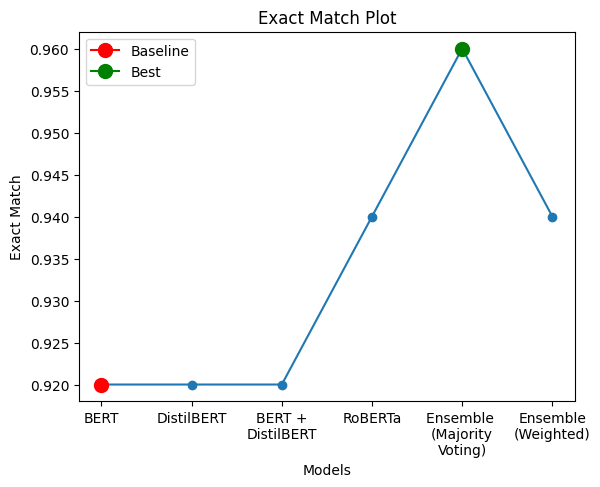

In [ ]:
import matplotlib.pyplot as plt

x = ['BERT', 'DistilBERT', 'BERT +\nDistilBERT','RoBERTa', 'Ensemble \n(Majority\nVoting)', 'Ensemble\n(Weighted)']
y = [0.920, 0.920, 0.920, 0.940, 0.960, 0.940]

plt.plot(x, y, marker='o')
plt.plot(x[0], y[0], marker='o', markersize=10, color="red", label='Baseline')

plt.plot(x[4], y[4], marker='o', markersize=10, color="green", label='Best')

#plt.xticks(rotation=90, ha='center')
plt.xlabel('Models')
plt.ylabel('Exact Match')
plt.title('Exact Match Plot')
plt.legend()
plt.show()


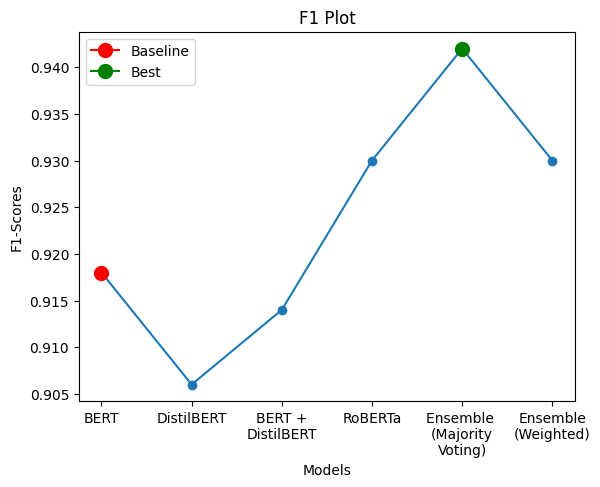

In [ ]:
import matplotlib.pyplot as plt

x = ['BERT', 'DistilBERT', 'BERT +\nDistilBERT','RoBERTa', 'Ensemble \n(Majority\nVoting)', 'Ensemble\n(Weighted)']
y = [0.918, 0.906, 0.914, 0.930, 0.942, 0.930]

plt.plot(x, y, marker='o')
plt.plot(x[0], y[0], marker='o', markersize=10, color="red", label='Baseline')

plt.plot(x[4], y[4], marker='o', markersize=10, color="green", label='Best')

#plt.xticks(rotation=90, ha='center')
plt.xlabel('Models')
plt.ylabel('F1-Scores')
plt.title('F1 Plot')
plt.legend()
plt.show()
